In [25]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using Random
using BlackBoxOptim
include("unicycle_env.jl")
include("controller.jl")
include("problem.jl")
include("safe_set.jl")

grad_phi (generic function with 2 methods)

In [26]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obs_radius = 0.5

0.5

In [72]:
function generate_moving_target(;fps=10, tf=2, v=nothing, v_lim=0.5, pos=nothing)
    T = tf*fps
    v = isnothing(v) ? [rand(), rand()]*v_lim*2 .- v_lim : v
    p = isnothing(pos) ? [0, 1.5] : pos
    return [Obstacle(p+v*(i/fps), v, obs_radius) for i in 0:T-1]
end

function get_Xref(x0, xg, T, dt)
    tf = T*dt
    dp = [xg[1]-x0[1], xg[2]-x0[2]]
    da = xg[4]-x0[4]
    a = atan(dp[2], dp[1])
    v = norm(dp)/tf
    v = max(min(v, 1),-1)
    vx = v * cos(a)
    vy = v * sin(a)
    Xref = [[x0[1]+vx*k*dt, x0[2]+vy*k*dt, v, a] for k = 1:T]
    Xref[end][3] = 0
    return Xref
end

function following(rp::RP, ctrl; fps=10, tf=2, targets=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    infeas=false
    for i in 1:T-1
        xg = [targets[i].center..., norm(targets[i].vel), 0]
        @show
        Xref = get_Xref(x, xg, fps, dt)
#         Xref = get_Xref(x, [targets[i].center..., norm(targets[i].vel), 0], fps, dt)
#         Xref = get_Xref(x, [targets[i].center..., norm(targets[i].vel), 0], fps, dt)
#         Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=[targets[i]], safety_index=safety_index)
        u, safe_set = timed_result.value
        dot_x = compute_output(net, [x; u])
        if !(dot_x ∈ safe_set)
            infeas=true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(safety_index, x, targets[i])
            @show p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

following (generic function with 1 method)

In [28]:

function following_samples()
    nx = 20
    ny = 20
    nv = 10
    nt = 10
    nov = 1
    xs = range(0,stop=5,length=nx)
    ys = range(0,stop=5,length=ny)
    vs = range(-1,stop=1,length=nv)
    θs = range(-π,stop=π,length=nt)
    ov1s = range(-0.,stop=0.,length=nov)
    ov2s = range(-0.,stop=0.,length=nov)
    samples = [([x,y,v,θ],[Obstacle([0.0, 0.0],[ov1,ov2],obs_radius)]) for x in xs, y in ys, v in vs, θ in θs, ov1 in ov1s, ov2 in ov2s];
    return samples
end
fol_samples = following_samples();

In [85]:

function exists_valid_control(safety_index, ctrl::ShootingController, x, obs, net, dt)
    safe_set = phi_safe_set(safety_index, x, obs, dt)
    phi_now = phi(safety_index, x, obs[1])
    phi_next_con = max(0, phi_now - safety_index.gamma * dt)
    for j in 1:ctrl.num_sample
        u_cand = rand(2) .* ctrl.u_lim * 2 - ctrl.u_lim
        x_cand = forward(net, x, u_cand, dt)
        phi_next = phi(safety_index, x_cand, obs[1])
        if phi_next < phi_next_con
            return true
        end
    end
    return false
end
function eval_following_index(coes)
    Random.seed!(1)
    margin, gamma, phi_power, dot_phi_coe = coes
    d_max = 2
    d_min = 1
    index = FollowingIndex(d_min, d_max, margin, gamma, phi_power, dot_phi_coe)
    cnt = 0
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in fol_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-6 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        evc = exists_valid_control(index, ctrl, x, obs, net, dt)
        cnt += 1
        valid += evc
        # if !evc
        #     @show sample
        # end
    end
    @show coes, valid/cnt
    return 1-valid/cnt
#     success_rate, phi0_vio_rate, infeas_rate  = following_stat(100, index)
#     infeas_cnt = length(fol_samples)-valid
#     @show coes, infeas_cnt, success_rate, phi0_vio_rate, infeas_rate
#     return Float64(length(fol_samples)-valid) - success_rate
end

eval_following_index (generic function with 1 method)

In [110]:
include("safe_set.jl")
Random.seed!(0)
bboptimize(eval_following_index; SearchRange = [(1e-3, 0.5), (1., 1.), (0.1,10.), (0.1, 10)], TraceMode=:verbose, MaxFuncEvals=100);

(coes, valid / cnt) = ([0.41200010648072877, 1.0, 1.7292014015234838, 1.8555555800160193], 0.9949624060150376)
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
(coes, valid / cnt) = ([0.16373910495418376, 1.0, 5.093514930259684, 7.546208898747808], 0.9981704260651629)
(coes, valid / cnt) = ([0.16373910495418376, 1.0, 4.134584631901263, 7.546208898747808], 0.9980451127819548)
7.14 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=0.001829574
DE modify state:
(coes, valid / cnt) = ([0.15362978964599225, 1.0, 3.2002861702466867, 2.515825418081089], 0.9935588972431078)
(coes, valid / cnt) = ([0.32436836651078, 1.0, 3.2002861702466867, 2.515825418081089], 0.9963408521303259)
17.39 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.0000), fitness=0.001829574
DE modify state:
(coes, valid / cnt) = ([0.06984

In [45]:
function draw_heat_plot(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in col_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        valid += exists_valid_control(index, ctrl, x, obs, net, dt)
    end
    return Float64(length(col_samples)-valid)
end



function find_infeas_states(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    d_min = 1
    d_max = 2
    index = FollowingIndex(d_min, d_max, margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    infeas_states = Dict()
    infeas_map = zeros(size(fol_samples)[1:2])
    for (idx, sample) in pairs(fol_samples)
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        feas = exists_valid_control(index, ctrl, x, obs, net, dt)
        valid += feas
        feas && continue
        haskey(infeas_states, (idx[1], idx[2])) || (infeas_states[(idx[1], idx[2])] = [])
        push!(infeas_states[(idx[1], idx[2])], sample)
        infeas_map[idx[1], idx[2]] += 1
    end
    return Float64(length(fol_samples)-valid), infeas_states, infeas_map
end

find_infeas_states (generic function with 1 method)

infeas_cnt1 = 1964.0


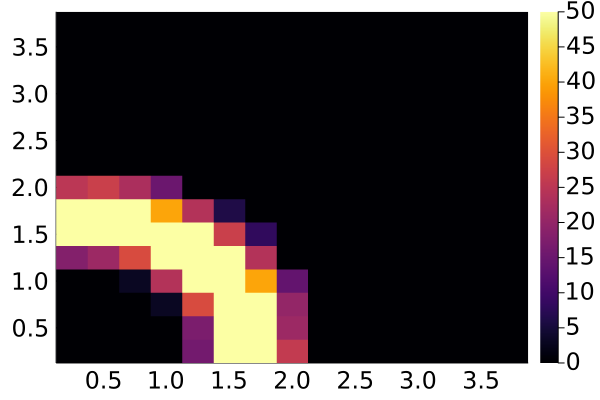

In [69]:
infeas_cnt1, infeas_states1, infeas_map1 = find_infeas_states([0.1, 5, 2, 1]);
@show infeas_cnt1
infeas_map = infeas_map1[1:15, 1:15]
p = plot(xtickfontsize=16,ytickfontsize=16,xguidefontsize=16,yguidefontsize=16,legendfontsize=16)
heatmap!(p, (1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))

infeas_cnt2 = 152.0


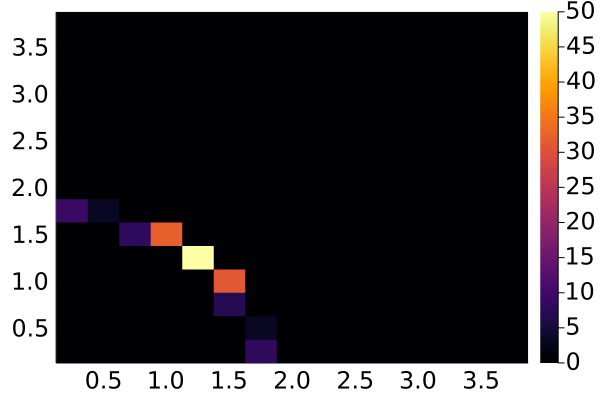

In [89]:
infeas_cnt2, infeas_states2, infeas_map2 = find_infeas_states([0.213584, 1.0, 4.27878, 17.3621]);
@show infeas_cnt2
infeas_map = infeas_map2[1:15, 1:15]
p = plot(xtickfontsize=16,ytickfontsize=16,xguidefontsize=16,yguidefontsize=16,legendfontsize=16)
heatmap!(p, (1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))

In [232]:

function following_stat(num, fi; )
    Random.seed!(127)
    success = 0
    phi0_vio_cnt = 0
    infeas_cnt = 0
    fps = 10
    tf = 1
    for j in 1:num
        x0 = [1.1+rand()*0.25, 0, rand()*0.2-0.1, -π+rand()*π/5-π/10]
        # xg = [1.0,0,0,-π]
        xg = [0,0,0,-π]
        obj_cost = [1,1,0.1,0.1]
        rp = RP(net, obj_cost, x0, xg)
        # obs = Obstacle([0, rand()*0.1-0.05], [0,0], obs_radius)
        obs = Obstacle([0, 0], [0,0], obs_radius)
        targets = [obs for i in 1:Int(tf*fps)]

        # ctrl = ShootingController(10000)
        ctrl = ShootingController(1000)
        Xtrack, Utrack, safe_sets, Xrefs, infeas = following(rp, ctrl, fps=fps, tf=tf, targets=targets, safety_index=fi, verbose=false);
        vio = false
        infeas_cnt += infeas
        for obs in targets
            for x in Xtrack
                if norm(x[1:2]-obs.center) < fi.d_min || norm(x[1:2]-obs.center) > fi.d_max
                    vio = true
                    break
                end 
            end
        end
        phi0_vio_cnt += vio
        success += 1 - (vio|infeas)
        # if j < 10
        #     visualize(Xtrack, targets=targets, xlims=[-3,3], ylims=[-1,5], fps=1000)
        # end
    end
    return success*1.0/num, phi0_vio_cnt*1.0/num, infeas_cnt*1.0/num
end

following_stat (generic function with 1 method)

In [229]:
fi = FollowingIndex(1, 2, 0.0, 1e-3, 1, 0)
following_stat(100, fi)

(0.0, 0.8, 1.0)

In [231]:
fi = FollowingIndex(1, 2, 0.01, 1, 2, 1)
following_stat(100, fi)

(0.17, 0.03, 0.83)

In [230]:
fi = FollowingIndex(1, 2, 0.489804, 1.0, 8.09224, 9.82608)
following_stat(100, fi)

(1.0, 0.0, 0.0)